In [93]:
# importing libraries
import pandas as pd
import numpy as np
from pathlib import Path as path
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
from IPython.display import Image, display
import re

import warnings
warnings.filterwarnings('ignore')

In [2]:
# paths
home_dir = path.cwd().parent
data_dir = home_dir / 'data'
interim_dir = data_dir / 'interim'

In [3]:
# dataset path
flat_house_data = interim_dir / 'flat-house-dataset.csv'

In [4]:
# reading the dataset
df = pd.read_csv(flat_house_data)

In [5]:
# changing the viewing option
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [6]:
# shape of the dataset
print(f"Shape of the dataset: {df.shape}")

Shape of the dataset: (3793, 17)


In [7]:
# checking rows in the dataset
df.head(1)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features
0,flat,maa bhagwati residency,NaN,0.45,5000.0,900.0,Carpet area: 900 (83.61 sq.m.),2.0,2,1,not available,4.0,West,1 to 5 Year Old,"['Chintapurni Mandir', 'State bank ATM', 'Pearl Dental Clinic', 'Taneja Hospital', 'Dr. Ashok Jain', 'Dr. Madan Clinic', 'Geeta Nursing Home Gurgaon', 'Chiranjiv Hospital', 'Dev Man Kathuria Clinic', 'Aryan Hospital', 'Kr Dental Hub', 'Swastik Maternity and Medical Centre', 'Satyam Hospital Gurgaon', 'Ravi Clinic and Health Care Centre', 'D.R. Rajnis Gupta Clinic', 'Esic Hospital Gurugram', 'Gurgaon Eye Centre', 'Bindal Clinic', 'Shiv Mahima Patient Care Bureau', 'Shree Krishna Hospital Gurgaon', 'M.S Hospital', 'My Care Clinic', 'Ankur Clinic and Maternity Home', 'Triveni Hospital Gurgaon', 'Shri Gobind Hospital', 'Navjeevan Hospital and Maternity Centre', 'Lal Superspeciality Hospital', 'Sparsh Hospital Gurgaon', 'Prateek Nursing Home And Polyclinic', 'Jain Sant Phool Chand Ji Charitable Hospital', 'Sarvodya Hospital', 'Bhatnagar Maternity and Nursing Home', 'Tirath Ram Hospitals Pvt Ltd', 'Dr. Sarvejeet Singh', 'Centre For Sight Gurgaon New Railway Road', 'Dr. Ajay S. Gupta Clinic', 'Kidney Clinic', 'Mangalam Hospital and Heart Centre Gurgaon', 'Sethi Hospital Gurgaon', 'Shubham Hospital Gurgaon', 'Kharbanda Maternity and Nursing Home', 'Gupta Hospital Gurgaon', 'Dentecare - Multispeciality Dental Clinic', 'State bank of india', 'Hdfc bank', 'Kotak bank', 'Indian bank', 'Pizza Hut', 'St. Michaels Sr. Sec. School', 'Dronacharya Government College']","['3 Fan', '4 Light', '1 Wardrobe', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']","['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Lift(s)', 'Water Storage', 'Visitor Parking']"


# Features in focus

## 1. areaWithType

In [8]:
# let's check few rows from 'price', 'area', 'areaWithType' columns
df[['price', 'area', 'areaWithType']].sample(5)

,price,area,areaWithType
2056,2.25,1653.0,Carpet area: 1433 (133.13 sq.m.)
2509,1.78,1424.0,Carpet area: 1424 (132.29 sq.m.)
2080,0.79,1298.0,Super Built up area 1298(120.59 sq.m.)
1455,1.85,2290.0,Super Built up area 2290(212.75 sq.m.)
2486,1.00,1110.0,Carpet area: 1110 (103.12 sq.m.)


---
### Initial Obeservations
- as we can see in above 'areawithType' columns
- four types of values are mentioned 
    - carpet area, 
    - built up area, 
    - super built up area and
    - plot area
- carpet area, built area and super built area are belong to flats
- and plot area belong to houses

### Definations

#### Carpet Area:
- `The actual usable area within a property`, excluding walls, balconies, and other common areas.
- Measured from wall to wall, where the carpet could be laid.
- Used for calculating the saleable price per square foot of usable space.

#### Built-Up Area:
- `Carpet area plus the area occupied by walls, balconies, staircases`, etc., within the individual property's boundaries.
- Represents the total area enclosed by the unit's walls.
- Often used for calculating maintenance charges and common area contributions.

#### Super Built-Up Area (SBA):
- `Built-up area plus a proportionate share of the common areas like lobbies, elevators, staircases, amenities`, etc., shared by all residents.
- Includes areas that benefit the residents indirectly but aren't part of their individual unit.
- Used for calculating the total cost of the property, including the share of common areas.

#### Example for better understanding
- A flat with a carpet area of 1000 sq ft, a built-up area of 1200 sq ft, and an SBA of 1500 sq ft.
- This means the actual usable space is 1000 sq ft, the individual unit including walls is 1200 sq ft, and the total cost includes a share of 300 sq ft of common areas.

In [9]:
# we will seperate these values from single column to individual columns

# function to extract the super built up area
def get_super_built_up_area(text):
    '''
    Extracts the super built-up area from a given text
    
    Args:
        text (str): A string containing information about the property, potentially including the super built-up area.

    Returns:
        float or None: The super built-up area extracted from the text, or None if not found.
    '''
    match = re.search(r'Super Built up area (\d+\.?\d*)', text)
    if match:
        return float(match.group(1))
    return None


# function to extract built-up area or carpet area
def get_area(text, area_type):
    '''
    Extracts the built up area or carpet area
    
    Args:
        text(str): A string containing information about the property, potentially including the super built-up area or carpet area.
        area_type(str) : The area you wish to extract from the text
    
    Returns:
        float or None: The carpet area or built-area extracted from the text, or None if not found
    '''
    match = re.search(area_type + r'\s*:\s*(\d+\.?\d*)' , text)
    if match:
        return float(match.group(1))
    return None


# some area values are given in sq.m. 
# we will maintain single unit i.e. sq.ft for all areas

# function checks if the area is in sq.m convert it sqft if needed
def convert_to_sqft(text:str, area_value):
    '''
    Converts an area value (potentially provided in sq.m.) to square feet (sqft).

    Args:
        text (str): A string containing the area information.
        area_value (float or None): An optional explicit area value.

    Returns:
        float or None: The converted area in sqft, or None if no area information is found or conversion is not possible.
    '''
    if area_value is None:
        return None
    match = re.search(r'{} \((\d+\.?\d*) sq.m.\)'.format(area_value), text)
    if match:
        sq_m_value = float(match.group(1))
        return sq_m_value * 10.7639  # conversion factor from sq.m. to sqft
    return area_value

In [10]:
# Extract Super Built up area and convert to sqft if needed
df['super_built_up_area'] = df['areaWithType'].apply(get_super_built_up_area)
df['super_built_up_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['super_built_up_area']), axis=1)

# Extract Built up area and to convert sqft if need
df['built_up_area'] = df['areaWithType'].apply(lambda x: get_area(x, "Built Up area"))
df['built_up_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['built_up_area']), axis=1)

# Extract carpet area and convert to sqft if needed
df['carpet_area'] = df['areaWithType'].apply(lambda x: get_area(x, 'Carpet area'))
df['carpet_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['carpet_area']), axis=1)

In [11]:
# checking few sample rows from above created columns
df[['price', 'property_type', 'area', 'areaWithType', 'super_built_up_area', 'built_up_area', 'carpet_area']].sample(5)

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
1418,0.53,flat,842.0,Carpet area: 845 (78.5 sq.m.),NaN,NaN,845.0
1139,0.35,flat,539.0,Carpet area: 547 (50.82 sq.m.),NaN,NaN,547.0
2425,1.60,flat,1960.0,Super Built up area 1960(182.09 sq.m.),1960.0,NaN,NaN
165,1.65,flat,2600.0,Super Built up area 2364(219.62 sq.m.),2364.0,NaN,NaN
1727,2.50,flat,2132.0,Super Built up area 2132(198.07 sq.m.)Built Up area: 2130 sq.ft. (197.88 sq.m.)Carpet area: 2129 sq.ft. (197.79 sq.m.),2132.0,2130.0,2129.0


In [12]:
# total rows of column 'price', 'property_type', 'area', 'areaWithType', 'super_built_up_area', 'built_up_area', 'carpet_area'
# where all values of 'super_built_up_area', 'built_up_area' and 'carpet_area' is present

df[~((df['super_built_up_area'].isnull()) | (df['built_up_area'].isnull()) |(df['carpet_area'].isnull()))][['price', 'property_type', 'area', 'areaWithType', 'super_built_up_area', 'built_up_area', 'carpet_area']].shape

(534, 7)

In [13]:
# checking first 10 rows, where we achieve above mentioned condition
df[~((df['super_built_up_area'].isnull()) | (df['built_up_area'].isnull()) |(df['carpet_area'].isnull()))][['price', 'property_type', 'area', 'areaWithType', 'super_built_up_area', 'built_up_area', 'carpet_area']].iloc[:10]

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
38,0.78,flat,1365.0,Super Built up area 1365(126.81 sq.m.)Built Up area: 1068.1 sq.ft. (99.23 sq.m.)Carpet area: 900 sq.ft. (83.61 sq.m.),1365.0,1068.1,900.0
100,2.10,flat,2000.0,Super Built up area 2000(185.81 sq.m.)Built Up area: 1600 sq.ft. (148.64 sq.m.)Carpet area: 1500 sq.ft. (139.35 sq.m.),2000.0,1600.0,1500.0
130,0.90,flat,1950.0,Super Built up area 1950(181.16 sq.m.)Built Up area: 1900 sq.ft. (176.52 sq.m.)Carpet area: 1854 sq.ft. (172.24 sq.m.),1950.0,1900.0,1854.0
133,0.90,flat,1530.0,Super Built up area 1530(142.14 sq.m.)Built Up area: 1450 sq.ft. (134.71 sq.m.)Carpet area: 1400 sq.ft. (130.06 sq.m.),1530.0,1450.0,1400.0
138,1.15,flat,2000.0,Super Built up area 2500(232.26 sq.m.)Built Up area: 2000 sq.ft. (185.81 sq.m.)Carpet area: 1750 sq.ft. (162.58 sq.m.),2500.0,2000.0,1750.0
147,1.95,flat,1350.0,Super Built up area 2191(203.55 sq.m.)Built Up area: 1650 sq.ft. (153.29 sq.m.)Carpet area: 1350 sq.ft. (125.42 sq.m.),2191.0,1650.0,1350.0
178,1.15,flat,1534.0,Super Built up area 1534(142.51 sq.m.)Built Up area: 1200 sq.ft. (111.48 sq.m.)Carpet area: 1103 sq.ft. (102.47 sq.m.),1534.0,1200.0,1103.0
200,0.90,flat,1446.0,Super Built up area 1285(119.38 sq.m.)Built Up area: 1185 sq.ft. (110.09 sq.m.)Carpet area: 975 sq.ft. (90.58 sq.m.),1285.0,1185.0,975.0
214,0.71,flat,1310.0,Super Built up area 1310(121.7 sq.m.)Built Up area: 1100 sq.ft. (102.19 sq.m.)Carpet area: 1000 sq.ft. (92.9 sq.m.),1310.0,1100.0,1000.0
222,1.10,flat,1110.0,Super Built up area 1110(103.12 sq.m.)Built Up area: 1100 sq.ft. (102.19 sq.m.)Carpet area: 1000 sq.ft. (92.9 sq.m.),1110.0,1100.0,1000.0


In [14]:
# Check the dataset where 'Plot' is mentioned in 'areaWithType' column
# checking these coloumns 'price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area'

df[df['areaWithType'].str.contains('Plot')][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].head()

# this rows in the dataset belong to 'house' category in 'property_type' feature

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
2933,5.25,house,2610.0,Plot area 290(242.48 sq.m.),NaN,NaN,NaN
2934,2.10,house,549.0,Plot area 61(51 sq.m.),NaN,NaN,NaN
2935,5.00,house,1161.0,Plot area 129(107.86 sq.m.),NaN,NaN,NaN
2936,3.00,house,558.0,Plot area 62(51.84 sq.m.),NaN,NaN,NaN
2937,4.50,house,1152.0,Plot area 128(107.02 sq.m.),NaN,NaN,NaN


In [15]:
# checking the missing values in the dataset
df.isnull().sum().sort_values(ascending=False)

sector                 3793
built_up_area          2608
super_built_up_area    1880
carpet_area            1855
facing                 1098
furnishDetails          981
features                631
nearbyLocations         175
price                    18
price_per_sqft           18
area                     18
floorNum                 17
agePossession             1
property_type             0
society                   0
balcony                   0
bathroom                  0
bedRoom                   0
areaWithType              0
additionalRoom            0
dtype: int64

In [16]:
# considering the dataset where all rows of 'super_built_up_area', 'built_up_area' and 'carpet_area' has missing values
all_nan_df = df[(df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & (df['carpet_area'].isnull())][['price', 'property_type', 'area', 'areaWithType', 'super_built_up_area', 'built_up_area', 'carpet_area']]
print(f"Size of the dataset: {all_nan_df.shape}")

Size of the dataset: (546, 7)


In [17]:
# checking first five rows of the dataset
all_nan_df.head()

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
2933,5.25,house,2610.0,Plot area 290(242.48 sq.m.),NaN,NaN,NaN
2934,2.10,house,549.0,Plot area 61(51 sq.m.),NaN,NaN,NaN
2935,5.00,house,1161.0,Plot area 129(107.86 sq.m.),NaN,NaN,NaN
2936,3.00,house,558.0,Plot area 62(51.84 sq.m.),NaN,NaN,NaN
2937,4.50,house,1152.0,Plot area 128(107.02 sq.m.),NaN,NaN,NaN


In [18]:
# storing the index of the rows in 'all_nan_df' dataframe
all_nan_index = df[(df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & (df['carpet_area'].isnull())][['price', 'property_type', 'area', 'areaWithType', 'super_built_up_area', 'built_up_area', 'carpet_area']].index

In [19]:
# function to extract the plot area from the 'areaWithType' column 
def extract_plot_area(area_with_type:str):
    match = re.search(r'Plot area (\d+\.?\d*)', area_with_type)
    return float(match.group(1)) if match else None

In [20]:
# applying the above function on 'areaWithType' column
# we will consider 'Plot area' as 'built_up_area'

all_nan_df['built_up_area'] = all_nan_df['areaWithType'].apply(extract_plot_area)

In [21]:
# checking some sample rows from 'all_nan_df'
all_nan_df.head(5)

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
2933,5.25,house,2610.0,Plot area 290(242.48 sq.m.),NaN,290.0,NaN
2934,2.10,house,549.0,Plot area 61(51 sq.m.),NaN,61.0,NaN
2935,5.00,house,1161.0,Plot area 129(107.86 sq.m.),NaN,129.0,NaN
2936,3.00,house,558.0,Plot area 62(51.84 sq.m.),NaN,62.0,NaN
2937,4.50,house,1152.0,Plot area 128(107.02 sq.m.),NaN,128.0,NaN


In [22]:
# converting the scale of 'built_up_area' column where 'property_type' is 'house'
# as some values mentioned in the dataset has unit of measurement as  yard and some values are in meters
# we will keep the unit standard, to 'sqft'
# the difference can be obeserved when we check the value of 'area' and 'built_up_area' in the same row

def convert_scale(row):
    if np.isnan(row['area']) or np.isnan(row['built_up_area']):
        return row['built_up_area']
    
    else:
        if round(row['area']/row['built_up_area']) == 9.0:
            return row['built_up_area'] * 9
        
        elif round(row['area']/row['built_up_area']) == 11.0:
            return row['built_up_area'] * 10.7
        
        else:
            return row['built_up_area']

In [23]:
# applying the above function on 'all_nan_df'
all_nan_df['built_up_area'] = all_nan_df.apply(convert_scale, axis=1)

In [24]:
# checking the dataset
all_nan_df.head()

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
2933,5.25,house,2610.0,Plot area 290(242.48 sq.m.),NaN,2610.0,NaN
2934,2.10,house,549.0,Plot area 61(51 sq.m.),NaN,549.0,NaN
2935,5.00,house,1161.0,Plot area 129(107.86 sq.m.),NaN,1161.0,NaN
2936,3.00,house,558.0,Plot area 62(51.84 sq.m.),NaN,558.0,NaN
2937,4.50,house,1152.0,Plot area 128(107.02 sq.m.),NaN,1152.0,NaN


In [25]:
# update the original dataframe
df.update(all_nan_df)

In [26]:
# checking the missing values in the dataset
df.isnull().sum().sort_values(ascending=False)

sector                 3793
built_up_area          2062
super_built_up_area    1880
carpet_area            1855
facing                 1098
furnishDetails          981
features                631
nearbyLocations         175
price                    18
price_per_sqft           18
area                     18
floorNum                 17
agePossession             1
property_type             0
society                   0
balcony                   0
bathroom                  0
bedRoom                   0
areaWithType              0
additionalRoom            0
dtype: int64

## 1. additionalRoom

In [27]:
# checking the unique values in the 'additionalRoom' column
df['additionalRoom'].value_counts()

additionalRoom
not available                                    1581
servant room                                      704
study room                                        248
others                                            224
pooja room                                        165
study room,servant room                            99
store room                                         99
pooja room,servant room                            82
pooja room,study room,servant room,store room      72
servant room,others                                60
pooja room,study room,servant room                 55
pooja room,study room,servant room,others          54
servant room,pooja room                            38
servant room,store room                            33
study room,others                                  29
pooja room,study room                              22
pooja room,others                                  17
pooja room,store room                              15
servant room,

In [28]:
# saving all the unqiue values in 'additionalRoom' column
all_values_additional_room = df['additionalRoom'].value_counts().index

# fetching unique values

# create a set of unique values
unique_additional_room = set()

for index, room in enumerate(all_values_additional_room):
    if room not in unique_additional_room:
        if ',' not in room:
            unique_additional_room.add(room)
        else:
            unique_room_names = set(room.split(','))
            unique_additional_room.update(unique_room_names)

In [29]:
# unique values 
print(f"Unique values in the 'additionaRoom' column:\n{unique_additional_room}")

Unique values in the 'additionaRoom' column:
{'servant room', 'not available', 'pooja room', 'study room', 'others', 'store room'}


In [30]:
# populate the new columns based on unique values in the 'additionRoom' column
for col in unique_additional_room:
    df[col] = df['additionalRoom'].str.contains(col).astype(int)

In [31]:
# checking the few rows after populating new columns
df[['additionalRoom', 'pooja room', 'store room', 'not available', 'servant room', 'study room', 'others']].sample(5)

,additionalRoom,pooja room,store room,not available,servant room,study room,others
3603,"pooja room,servant room",1,0,0,1,0,0
1082,not available,0,0,1,0,0,0
2632,not available,0,0,1,0,0,0
1747,not available,0,0,1,0,0,0
2304,not available,0,0,1,0,0,0


## 3.agePossession

In [32]:
# unqiue values in "agePossession" column
df['agePossession'].value_counts()

agePossession
1 to 5 Year Old       1672
5 to 10 Year Old       573
0 to 1 Year Old        529
undefined              332
10+ Year Old           309
Under Construction      88
Within 6 months         70
Within 3 months         26
Dec 2023                22
By 2023                 19
By 2024                 17
Dec 2024                16
Mar 2024                14
Oct 2024                 8
Jan 2024                 8
Aug 2023                 7
Dec 2025                 7
Jun 2024                 7
Nov 2023                 5
Aug 2024                 4
Sep 2023                 4
Jul 2024                 4
Oct 2023                 4
By 2025                  4
May 2024                 3
Feb 2024                 3
Jan 2025                 3
Nov 2024                 3
Jul 2025                 2
Jun 2027                 2
Mar 2025                 2
Jan 2026                 2
Aug 2025                 2
Oct 2025                 2
By 2027                  2
Jul 2027                 2
Apr 2026      

In [33]:
# properly categorising the 'agePossession' column

def categorize_age_possession(value):
    if pd.isna(value):
        return "Undefined"
    if "0 to 1 Year Old" in value or "Within 6 months" in value or "Within 3 months" in value:
        return "New Property"
    if "1 to 5 Year Old" in value:
        return "Relatively New"
    if "5 to 10 Year Old" in value:
        return "Moderately New"
    if "10+ Year Old" in value:
        return "Old Property"
    if "Under Construction" in value or "By" in value:
        return "Under Construction"
    try:
        # for entries like 'May 2024'
        int(value.split(" ")[-1])
        return "Under Construction"
    except:
        return "Undefined"

In [34]:
# applying the above function on 'agePossession' column
df['agePossession'] = df['agePossession'].apply(categorize_age_possession)

In [35]:
# checking the update
df['agePossession'].value_counts()

agePossession
Relatively New        1672
New Property           625
Moderately New         573
Undefined              333
Old Property           309
Under Construction     281
Name: count, dtype: int64

## 4.FurnishDetails

In [36]:
# checking few rows from 'furnishDetails' and 'features' columns
df[['furnishDetails', 'features']].sample(5)

,furnishDetails,features
1182,NaN,"['Security / Fire Alarm', 'Power Back-up', 'Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Separate entry for servant room', 'Recently Renovated', 'Bank Attached Property', 'Piped-gas', 'Visitor Parking', 'Park', 'Security Personnel', 'Natural Light', 'Internet/wi-fi connectivity', 'Waste Disposal', 'Rain Water Harvesting']"
730,"['3 Wardrobe', '1 Water Purifier', '11 Fan', '1 Exhaust Fan', '3 Geyser', '20 Light', '1 Modular Kitchen', '1 Chimney', '1 Curtains', 'No AC', 'No Bed', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine']","['Centrally Air Conditioned', 'Water purifier', 'Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Bank Attached Property', 'Piped-gas', 'Internet/wi-fi connectivity', 'Recently Renovated', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Spacious Interiors', 'Low Density Society', 'Waste Disposal', 'Rain Water Harvesting', 'Water softening plant', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center']"
3151,NaN,NaN
94,"['1 Modular Kitchen', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Light', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']","['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Intercom Facility', 'Lift(s)', 'Park', 'Visitor Parking']"
518,"['4 Wardrobe', '6 Fan', '1 Fridge', '5 Geyser', '1 Washing Machine', '1 Stove', '1 Microwave', '4 Curtains', '1 Modular Kitchen', '6 AC', 'No Bed', 'No Chimney', 'No Dining Table', 'No Exhaust Fan', 'No Light', 'No Sofa', 'No TV', 'No Water Purifier']","['Centrally Air Conditioned', 'Water purifier', 'Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Bank Attached Property', 'Piped-gas', 'Internet/wi-fi connectivity', 'Recently Renovated', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Spacious Interiors', 'Low Density Society', 'Waste Disposal', 'Rain Water Harvesting', 'Water softening plant', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center']"


In [37]:
# Extract all unique furnishings from 'furnishDetails' column
all_furnishings = []
for detail in df['furnishDetails'].dropna():
    furnishings = detail.replace('[', '').replace(']', '').replace("'", '').split(', ')
    all_furnishings.extend(furnishings)
    
unique_furnishings = list(set(all_furnishings))

In [38]:
# Define a function to extract the count of a furnishings from the furnishingDetails
def get_furnishing_count(details, furnishing):
    # Check for explicit absence of the furnishing
    if isinstance(details, str):
        if f"No {furnishing}" in details:
            return 0
        # Compile a regular expression pattern to match the furnishing count
        pattern = re.compile(rf"(\d+) {furnishing}")  # Use f-string for safer formatting
        
        # Search for the pattern and extract the count
        match = pattern.search(details)
        if match:
            return int(match.group(1))
        
         # Check for simple presence (without count)
        elif furnishing in details:
            return 1
    
    # No match found
    return 0


# simplifying the furnishings list by removing 'No' prefix and numbers
columns_to_include = [re.sub(r'No |\d+', '', furnishing).strip() for furnishing in unique_furnishings]

# Getting unique furnishings
columns_to_include = list(set(columns_to_include))

# removing empty string
columns_to_include = [furnishing for furnishing in columns_to_include if furnishing]

# create new column for each unique furnishing and populate with counts
for furnishings in columns_to_include:
    df[furnishings] = df['furnishDetails'].apply(lambda x: get_furnishing_count(x, furnishings))
    
# create a new dataframe with the required columns 
furnishings_df = df[['furnishDetails'] + columns_to_include]

In [39]:
# checking the shape of the dataframe
print(f"furnishings_df shape: {furnishings_df.shape}")

furnishings_df shape: (3793, 19)


In [40]:
# dropping the column 'furnishDeatils' from 'furnishings_df'
furnishings_df.drop(columns=['furnishDetails'], inplace=True)

In [41]:
# checking few rows from 'furnishings_df' 
furnishings_df.sample(5)

,Water Purifier,Exhaust Fan,Washing Machine,Fridge,Curtains,Bed,Fan,Stove,Geyser,Chimney,Microwave,AC,TV,Dining Table,Wardrobe,Sofa,Light,Modular Kitchen
2089,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2179,1,1,1,1,9,0,4,1,2,1,1,2,1,1,2,1,14,1
289,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
322,0,0,0,0,0,0,7,0,5,1,0,6,0,0,4,0,10,0
2524,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [42]:
# scaling the 'furnishings_df'
scaler = StandardScaler()
scaled_data = scaler.fit_transform(furnishings_df)

In [43]:
# Initialize an empty list to store the Within-Cluster Sum of squares (WCSS) values for different cluster numbers
wcss_reduced = []

# Iterate through different cluster numbers from 1 to 10
for i in tqdm(range(1, 11)):
    
    # Create a KMeans model with the current cluster number
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42) # k-means++ for better initialization
    
    # fit the model to the scaled data
    kmeans.fit(scaled_data)
    
    # append the model's inertia (WCSS) to the list
    wcss_reduced.append(kmeans.inertia_)

  0%|          | 0/10 [00:00<?, ?it/s]

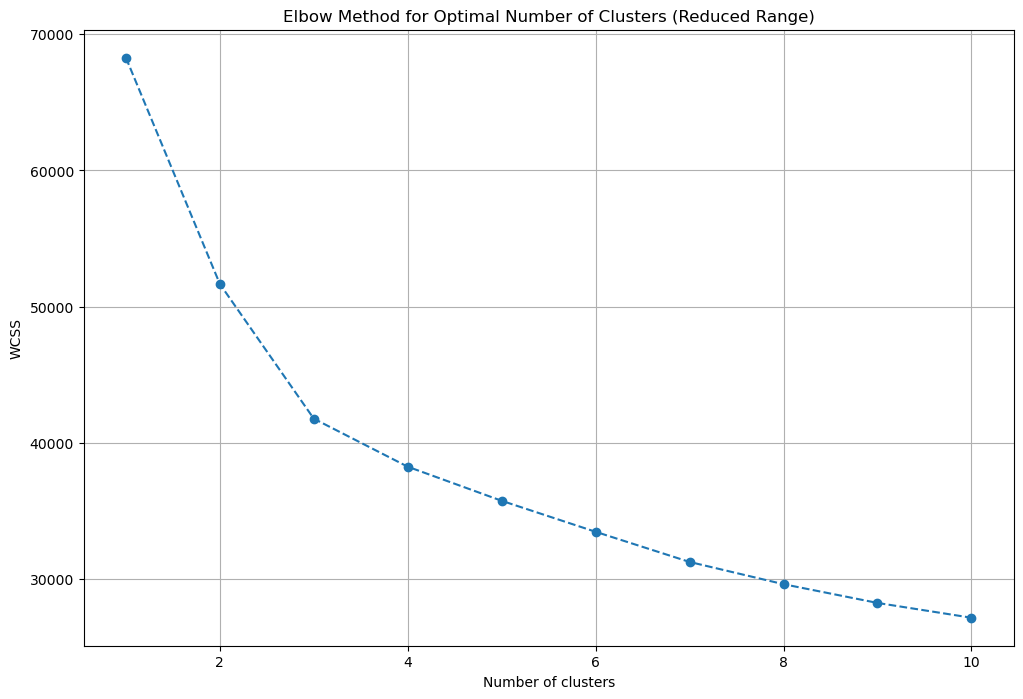

In [44]:
# plotting the results for better visualization
plt.figure(figsize=(12, 8))
plt.plot(range(1, 11), wcss_reduced, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters (Reduced Range)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [45]:
# from the above elbow we can see that the optimum number of clusters will be 3
n_clusters = 3

# fit the KMeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(scaled_data)

# predict the cluster assignments for each row
cluster_assignments = kmeans.predict(scaled_data)

In [50]:
# removing the extra 'furnishings' columns

# checking the column locations
for i in df.columns:
    if i not in df.iloc[:, :-18].columns:
        print(i)

Water Purifier
Exhaust Fan
Washing Machine
Fridge
Curtains
Bed
Fan
Stove
Geyser
Chimney
Microwave
AC
TV
Dining Table
Wardrobe
Sofa
Light
Modular Kitchen


In [52]:
# assign a dataframe for the selected columns 
df = df.iloc[:, :-18]

(3793,)

In [55]:
# assigning the clusters assigned to 'furnishing_type' column
df['furnishing_type'] = cluster_assignments

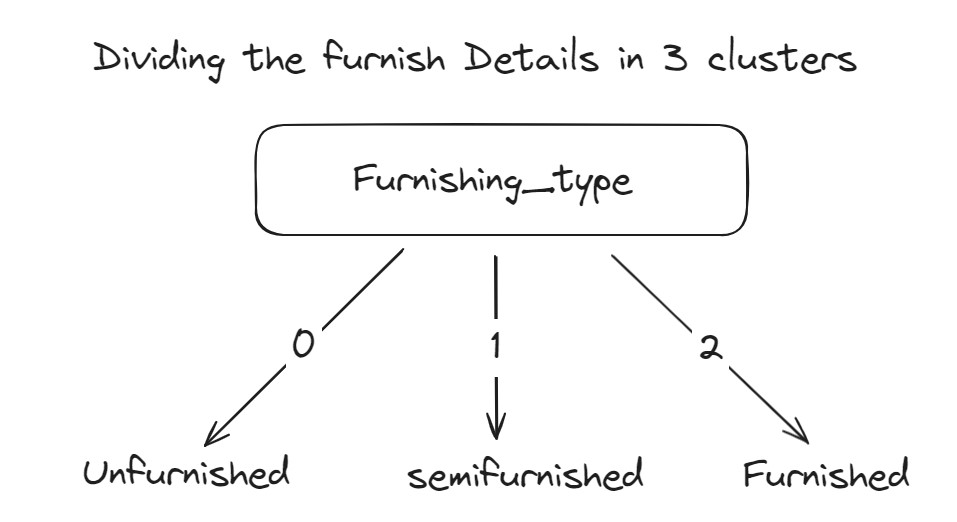

In [100]:
# path for the image
docs_imgs = home_dir / 'docs/imgs'
img_file = docs_imgs / 'furnishing_clusters.jpg'

display(Image(filename=img_file, embed=True, width=500, height=800))

In [110]:
# setting the seed value
np.random.seed(42)

# checking each row from each condition
pd.concat([
    df[df['furnishing_type']==0][['furnishDetails', 'furnishing_type']].sample(1),
    df[df['furnishing_type']==1][['furnishDetails', 'furnishing_type']].sample(1),
    df[df['furnishing_type']==2][['furnishDetails', 'furnishing_type']].sample(1),
    ])

,furnishDetails,furnishing_type
1659,"['3 Wardrobe', '1 Fridge', '8 Fan', '1 Exhaust Fan', '3 Geyser', '1 Washing Machine', '32 Light', '1 Chimney', '1 Curtains', 'No AC', 'No Bed', 'No Dining Table', 'No Modular Kitchen', 'No Microwave', 'No Sofa', 'No Stove', 'No TV', 'No Water Purifier']",0
984,"['2 AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Modular Kitchen', 'No Light', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']",1
2145,"['1 Bed', '1 Water Purifier', '1 Fan', '1 Fridge', '1 Sofa', '1 Exhaust Fan', '1 Light', '1 Chimney', '1 Curtains', '1 AC', 'No Dining Table', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine']",2


### 5.features

In [112]:
# checking few rows
df[['features']].sample(5)

,features
3386,['Water Storage']
3584,"['Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'Maintenance Staff', 'Water Storage', 'Park', 'Visitor Parking', 'Waste Disposal', 'Rain Water Harvesting']"
3631,"['Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'Maintenance Staff', 'Park', 'Piped-gas', 'Visitor Parking', 'Security Personnel', 'Airy Rooms', 'Spacious Interiors']"
132,NaN
1663,"['Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'Centrally Air Conditioned', 'High Ceiling Height', 'Maintenance Staff', 'Water Storage', 'No open drainage around', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Spacious Interiors', 'Low Density Society', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center']"


In [113]:
# checking null values
print(f"Missing values in 'features' column: {df['features'].isnull().sum()}")

Missing values in 'features' column: 631


In [ ]:
# as we can see in above cell, 'features' has many missing values
# we can fill these values from another dataset, 'appratment' dataset

In [122]:
raw_dir = data_dir / 'raw' # raw directory path
appartments_file = raw_dir / "appartments.csv" # appartments.csv file path

# reading the dataset with pandas
app_df = pd.read_csv(appartments_file)

# checking first two rows of the dataset
app_df.head(2)

,PropertyName,PropertySubName,NearbyLocations,LocationAdvantages,Link,PriceDetails,TopFacilities
0,Smartworld One DXP,"2, 3, 4 BHK Apartment in Sector 113, Gurgaon","['Bajghera Road', 'Palam Vihar Halt', 'DPSG Palam Vihar', 'Park Hospital', 'Gurgaon Railway Station']","{'Bajghera Road': '800 Meter', 'Palam Vihar Halt': '2.5 KM', 'DPSG Palam Vihar': '3.1 KM', 'Park Hospital': '3.1 KM', 'Gurgaon Railway Station': '4.9 KM', 'The NorthCap University': '5.4 KM', 'Dwarka Expy': '1.2 KM', 'Hyatt Place Gurgaon Udyog Vihar': '7.7 KM', 'Dwarka Sector 21, Metro Station': '7.2 KM', 'Pacific D21 Mall': '7.4 KM', 'Indira Gandhi International Airport': '14.7 KM', 'Hamoni Golf Camp': '6.2 KM', 'Fun N Food Waterpark': '8.8 KM', 'Accenture DDC5': '9 KM'}",https://www.99acres.com/smartworld-one-dxp-sector-113-gurgaon-npxid-r400415,"{'2 BHK': {'building_type': 'Apartment', 'area_type': 'Carpet Area', 'area': '1,370 sq.ft.', 'price-range': '₹ 2 - 2.4 Cr'}, '3 BHK': {'building_type': 'Apartment', 'area_type': 'Carpet Area', 'area': '1,850 - 2,050 sq.ft.', 'price-range': '₹ 2.25 - 3.59 Cr'}, '4 BHK': {'building_type': 'Apartment', 'area_type': 'Carpet Area', 'area': '2,600 sq.ft.', 'price-range': '₹ 3.24 - 4.56 Cr'}}","['Swimming Pool', 'Salon', 'Restaurant', 'Spa', 'Cafeteria', 'Sun Deck', '24x7 Security', 'Club House', 'Gated Community']"
1,M3M Crown,"3, 4 BHK Apartment in Sector 111, Gurgaon","['DPSG Palam Vihar Gurugram', 'The NorthCap University', 'Park Hospital, Palam Vihar', 'Pacific D21 Mall', 'Palam Vihar Halt Railway Station']","{'DPSG Palam Vihar Gurugram': '1.4 Km', 'The NorthCap University': '4.4 Km', 'Park Hospital, Palam Vihar': '1.4 Km', 'Pacific D21 Mall': '8.2 Km', 'Palam Vihar Halt Railway Station': '1.2 Km', 'Dwarka Sector 21 Metro Station': '8.1 Km', 'Dwarka Expressway': '450 m', 'Fun N Food Water Park': '8.1 Km', 'Indira Gandhi International Airport': '14.1 Km', 'Tau DeviLal Sports Complex': '11.2 Km', 'Hamoni Golf Camp': '5 Km', 'Hyatt Place': '6.1 Km', 'Altrade Business Centre': '11.2 Km'}",https://www.99acres.com/m3m-crown-sector-111-gurgaon-npxid-r404068,"{'3 BHK': {'building_type': 'Apartment', 'area_type': 'Super Built-up Area', 'area': '1,605 - 2,170 sq.ft.', 'price-range': '₹ 2.2 - 3.03 Cr'}, '4 BHK': {'building_type': 'Apartment', 'area_type': 'Super Built-up Area', 'area': '2,248 - 2,670 sq.ft.', 'price-range': '₹ 3.08 - 3.73 Cr'}}","['Bowling Alley', 'Mini Theatre', 'Manicured Garden', 'Swimming Pool', 'Flower Garden', 'Reading Lounge', 'Golf Course', 'Barbecue', 'Sauna']"


In [124]:
# shape of the appartment dataset
print(f"appartment dataset shape: {app_df.shape}")

appartment dataset shape: (247, 7)


In [126]:
# columns in the dataset
app_df.columns

Index(['PropertyName', 'PropertySubName', 'NearbyLocations',
       'LocationAdvantages', 'Link', 'PriceDetails', 'TopFacilities'],
      dtype='object')

In [128]:
# lowering the text in 'PropertyName' column
app_df['PropertyName'] = app_df['PropertyName'].str.lower()

In [131]:
# creating a temporary df, which will hold the rows with missing values in 'feature' column
temp_df = df[df['features'].isnull()]

In [132]:
# shape of the temporary dataframe
temp_df.shape

(631, 45)